In [1]:

import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import gzip
import numpy as np
import pandas as pd

# classifiers and performance metrics
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import FastICA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

Total number of images selected:
10000


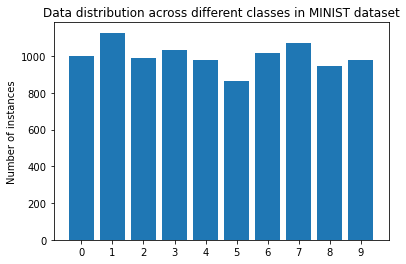

In [2]:

###############################################################################
###        MINIST datasets, hand writing digits images               ##########
###############################################################################
### downloaded from  http://yann.lecun.com/exdb/mnist/
### the training dataset contain 60,000 examples


image_size = 28
num_images = 60000


# load each training examples, an individual images
f = gzip.open('data/train-images-idx3-ubyte.gz','r')
f.read(16)
buf = f.read(image_size * image_size * num_images)
data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
digit_img = data.reshape(num_images, image_size, image_size, 1)

# load the related training labels
f = gzip.open('data/train-labels-idx1-ubyte.gz','r')
labels = []
f.read(8)
for i in range(0,num_images):   
    buf = f.read(1)
    one_label = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)[0]
    labels.append(one_label)
    
    
# select 16000 examples to conduct our experiment in this assignment
selected_length = 10000
img_data   = digit_img[0:selected_length].reshape(selected_length, image_size*image_size)
img_labels = labels[0:selected_length]

print('Total number of images selected:')
print(len(img_data))


# investigate the number of classes in each case.
num_instances = []  # store the number of instances for each class
total_class = list(set(img_labels)) # figure out how many classes are there in the training data
img_labels_array = np.asarray(img_labels)
for a_class in total_class:
    num_instances.append( len(np.where(img_labels_array == a_class)[0]) ) 

# plot a figure to show the number of instances in each class in the training data
#plt.figure()
fig, ax = plt.subplots()
p1 = ax.bar(total_class, num_instances)
plt.ylabel('Number of instances')
plt.title('Data distribution across different classes in MINIST dataset')
#ax.bar_label(p1, padding=2)
ax.set_xticks(total_class)


# normalize the data
scalar      = StandardScaler()
scaled_data = scalar.fit_transform(img_data)
mydata = scaled_data 
mylabels = img_labels;

## Define helper functions
Will be used later for plotting

In [3]:

# some helper functions will be used later to plot the figures.

# A useful post to read about Silhouette Coefficient Analysis can be found here: 
# https://towardsdatascience.com/k-means-clustering-how-it-works-finding-the-optimum-number-of-clusters-in-the-data-13d18739255c


def silhouette_avg_plot(mydata, max_cluster, model_type = 'EM'):
    
    '''
    Generate figures for average silhouette score.
    model_type, 'EM' or 'kmeans'
    '''
    silhouette_scores = [] # collect the average silhouette score for each given hyperparameter of cluster
    distortions = []       # used to plot the distortion curve and find the elbow
    
    if len(max_cluster) ==2:
          start = max_cluster[0]; end = max_cluster[1];
    else: start = 0; end = max_cluster;

    if model_type == 'EM':

        for cluser in range(start,end):

          print('woring on clustering: ', cluser)
          EM_model = GaussianMixture(n_components=cluser,random_state=0)
          EM_model.fit(mydata)
          cluster_labels = EM_model.predict(mydata)
          
          # Compute the average scores for each cluster
          silhouette_avg = silhouette_score(mydata, cluster_labels)
          silhouette_scores.append(silhouette_avg)  # track the average silhouette_scores

        plt.figure()
        plt.plot(np.arange(start,end), silhouette_scores, '--.')
        plt.ylabel('silhouette_avg score')
        plt.xlabel('Number of clusters')
        plt.title('Silhouette avgerage score over iterations')
          
    elif model_type == 'kmeans':  
        #for cluser in range(2,max_cluster):   
        silhouette_scores = [] # collect the average silhouette score for each given hyperparameter of cluster
        distortions = []       # used to plot the distortion curve and find the elbow

        for cluser in range(start,end):
            print('woring on clustering: ', cluser)
            kmeans_model = KMeans(n_clusters=cluser, random_state=0)
            kmeans_model.fit(mydata)
            cluster_labels = kmeans_model.labels_

            # Compute the average scores for each cluster
            silhouette_avg = silhouette_score(mydata, cluster_labels)
            silhouette_scores.append(silhouette_avg)  # track the average silhouette_scores

            distortions.append(kmeans_model.inertia_) # track the distortion

        plt.figure()
        plt.plot(np.arange(start,end), silhouette_scores, '--.')
        plt.ylabel('silhouette_avg score')
        plt.xlabel('Number of clusters')
        plt.title('Silhouette avgerage score over iterations')

        plt.figure()
        plt.plot(np.arange(start,end), distortions, '--.')
        plt.ylabel('Distortion')
        plt.xlabel('Number of clusters')
        plt.title('Distortion over iterations')


        
        
        
def silhouette_and_data_plot(cluser, mydata,  attributes=None, max_cluster=10,
                             model_type='kmeans', data_type='normal',
                             xlim=[],ylim=[], zlim=[]):
    
    '''
    Generate figures for silhouette scores for all samples.
    
    Inputs:
    model_type,
        what type of clustering model to use, 'kmeans' or 'EM'
    data_type,
        what type of data used,
        'normal':  normal dataset without dimensionality reduction.
        'reduced':  dataset with dimensionality reduction.
    '''
    
    X = mydata
    
    if model_type=='kmeans':
        kmeans_model = KMeans(n_clusters=cluser, random_state=0)
        kmeans_model.fit(X)
        cluster_labels = kmeans_model.labels_
        
    elif model_type=='EM':
        EM_model = GaussianMixture(n_components=cluser,random_state=0)
        EM_model.fit(mydata)
        cluster_labels = EM_model.predict(mydata)    

    # Compute the average scores for each cluster
    silhouette_avg = silhouette_score(X, cluster_labels)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    ###### Reorganize the silhouette score for each cluster and sort them
    ###### Will use later to plot the figure for silhouette score for each sample
    # this section of code is modified from this post
    # https://towardsdatascience.com/k-means-clustering-how-it-works-finding-the-optimum-number-of-clusters-in-the-data-13d18739255c

    #################################################
    # Create a subplot with 1 row and 2 columns

    fig = plt.figure()
    ax1 = fig.add_subplot()

    #fig.set_size_inches(18, 7)
    ##############################################################################
    #########   first subplot, silhouette scores for all samples    ##############
    ##############################################################################
    y_lower = 10
    for i in range(cluser):
        # for each cluster, aggregate the silhouette scores for samples and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / max_cluster)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")   
    ax1.set_yticks([])  # Clear the yaxis labels / ticks


    ##############################################################################
    #########   second subplot, clusters with first two or three features    ##############
    ##############################################################################

    fig = plt.figure()
    ax2 = fig.add_subplot(projection='3d')
    
    if data_type =='normal':
        a_idx=0; b_idx=1; c_idx=6;
    elif data_type =='reduced':
        a_idx=0; b_idx=1; c_idx=2;

    colors = cm.nipy_spectral(cluster_labels.astype(float) / cluser)
    ax2.scatter(X[:, a_idx], X[:, b_idx], X[:, c_idx],  marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    ## Labeling the clusters
    #centers = kmeans_model.cluster_centers_
    ## Draw white circles at cluster centers
    #ax2.scatter(centers[:, a_idx], centers[:, b_idx], centers[:, c_idx], marker='o',
    #            c="white", alpha=1, s=200, edgecolor='k')

    #for i, c in enumerate(centers):
    #    ax2.scatter(c[a_idx], c[b_idx], c[c_idx], marker='$%d$' % i, alpha=1,
    #                s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data." "with n_clusters = %d" % cluser)
    if data_type =='normal':
        ax2.set_xlabel(attributes[a_idx])
        ax2.set_ylabel(attributes[b_idx])
        ax2.set_zlabel(attributes[c_idx])

    if data_type =='reduced':
        ax2.set_xlabel('1st component')
        ax2.set_ylabel('2nd component')
        ax2.set_zlabel('3rd component')
        
    if len(xlim)==2: ax2.set_xlim(xlim)
    if len(ylim)==2: ax2.set_ylim(ylim)
    if len(zlim)==2: ax2.set_zlim(zlim)
      
        
def bic_plot(mydata, max_cluster):        
    '''
    At this moment, BIC plot is only work for EM clustering model here
    
    Code in this section was adapted from this post.
    https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4
    '''

    # Bayesin Information Criterion score when using clustering from 2 to 10
    X = mydata
    ncluster = np.arange(2, max_cluster+1)
    bics=[]; bics_err=[];

    for acluster in ncluster:
        tmp_bic=[]
        # also select some random state to recompute the model when given a number of clusters    
        for randomstate in range(1,100, 5):
            EM_model=GaussianMixture(acluster, random_state=randomstate).fit(X)
            tmp_bic.append(EM_model.bic(X))
        val=np.mean(tmp_bic); err=np.std(tmp_bic);
        bics.append(val); bics_err.append(err);   # store the computation results for later plotting use.


    # plot the BIC score as the number of clusters
    fig = plt.figure()
    ax1 = fig.add_subplot()
    ax1.errorbar(ncluster, bics, yerr=bics_err, label='BIC')
    ax1.set_title("BIC Scores")
    ax1.set_xticks(ncluster)
    ax1.set_xlabel("Number of Clusters")
    ax1.set_ylabel("BIC")

    # plot the gradient of the BIC score
    fig = plt.figure()
    ax2 = fig.add_subplot()
    ax2.errorbar(ncluster, np.gradient(bics), yerr=bics_err, label='BIC')
    ax2.set_title("Gradient of BIC Scores")
    ax2.set_xticks(ncluster)
    ax2.set_xlabel("Number of Clusters")
    ax2.set_ylabel("grad(BIC)")




## ICA

Kurtosis

Component i: 10
Component i: 20
Component i: 40
Component i: 60
Component i: 80
Component i: 100
Component i: 120
Component i: 140
Component i: 160
Component i: 180
Component i: 200


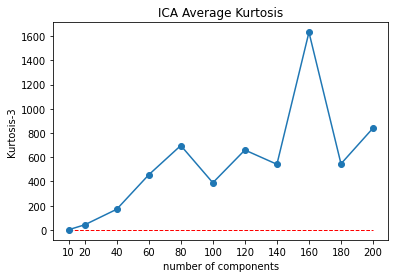

In [22]:
# Kurtosis

kurt = []
kurt = []
start = 10
end = 200
ncomponent = [10, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
#ncomponent = [140]
for i in ncomponent:
    print('Component i:', i)
    ica = FastICA(n_components=i, max_iter=10000, tol=0.1,random_state=12)
    data_reduced_ICA = ica.fit_transform(mydata)
    kurt_i_component = pd.DataFrame(data_reduced_ICA)
    kurt_i_component = kurt_i_component.kurt(axis=0)
    kurt_i_component = kurt_i_component.abs().mean()-3
    kurt.append(kurt_i_component)

plt.plot(ncomponent, kurt, '-o')
plt.xlabel('number of components')
plt.xticks(ncomponent)
plt.ylabel('Kurtosis-3')
plt.title("ICA Average Kurtosis")
plt.hlines(0, ncomponent[0], ncomponent[-1], linewidth=1, linestyle='--', color='r')
plt.show()

Working n_component= 10


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


0.7995
Working n_component= 20


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


0.87
Working n_component= 40


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


0.899
Working n_component= 60


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


0.9095
Working n_component= 80


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


0.9125
Working n_component= 100


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


0.893
Working n_component= 120


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


0.9115
Working n_component= 140


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


0.902
Working n_component= 160


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


0.898
Working n_component= 180


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


0.8895
Working n_component= 200
0.8935


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


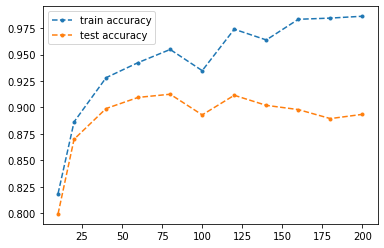

In [30]:
####################################################################################
## USING NN ALGORITHM TO TEST WHICH n_components HAS WHAT DECODING ACCURACY ##

test_acc_list = []
train_acc_list = []

ncomponent = [10, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
for n_components in ncomponent:
    print('Working n_component=', n_components)
    FICA_data=FastICA(n_components=n_components)
  
    # conduct dimensionality reduction using ICA
    data_reduced_ICA = FICA_data.fit_transform(mydata)

    # after getting dimensionality reduced data, traing this data into training the testing data    
    X_train, X_test, y_train, y_test = train_test_split(data_reduced_ICA, mylabels, test_size=0.2, random_state=4)

    # initialize the bosting mode using the best hyperparameters from assignment1
    # with ICA reduced dimentionality data
    # initialize the mode using the best hyperparameters

    model = MLPClassifier(hidden_layer_sizes=(30,50,30), solver = 'adam',random_state=1, verbose=False,
                        activation         = 'relu',
                        alpha              = 0.001,  # L2 penalty (regularization term) parameter.
                        learning_rate_init = 0.001,  # learning rate
                        shuffle            = False,  # whether to shuffle the data or not
                        )
    
    model     = model.fit(X_train, y_train)
    train_acc = model.score(X_train, y_train)
    pred_all  = model.predict(X_test)
    test_acc  = metrics.accuracy_score(y_test, pred_all)
    test_acc_list.append(test_acc)
    print(test_acc)
    train_acc_list.append(train_acc)

plt.figure()
plt.plot(ncomponent, train_acc_list, '--.')
plt.plot(ncomponent, test_acc_list, '--.')
plt.legend(['train accuracy','test accuracy'])
plt.xlabel('Accuracy')
plt.ylabel('Number of components')

In [4]:
# Based on above results, we use n_components=9
# conduct dimensionality reduction using ICA
FICA_data=FastICA(n_components=160)
data_reduced_ICA = FICA_data.fit_transform(mydata)

print('Raw data shape:')
print(mydata.shape)
print('Reduced data shape:')
print(data_reduced_ICA.shape)

Raw data shape:
(10000, 784)
Reduced data shape:
(10000, 160)


### k-means clustering on data with reduced dimensionality using ICA

woring on clustering:  4
woring on clustering:  5
woring on clustering:  6
woring on clustering:  7
woring on clustering:  8
woring on clustering:  9
woring on clustering:  10
woring on clustering:  11
woring on clustering:  12
woring on clustering:  13
woring on clustering:  14


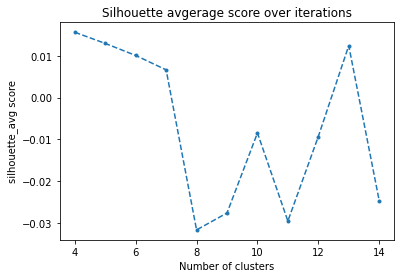

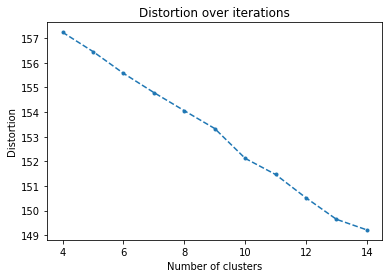

In [5]:
# Average silhouette score when using clustering from 2 to 10
max_cluster = [4, 15];
model_type = 'kmeans'
silhouette_avg_plot(data_reduced_ICA, max_cluster, model_type = model_type)


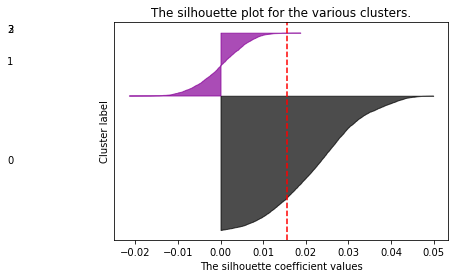

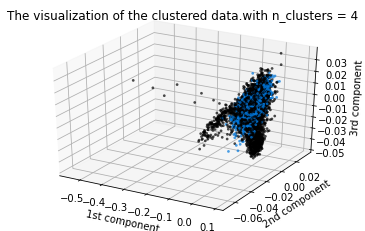

In [7]:

# plot clustering with 3 and 4 to see how the cluster look like
for cluser in [4]:
    silhouette_and_data_plot(cluser, data_reduced_ICA, model_type='kmeans', data_type='reduced')

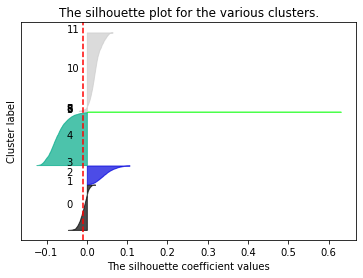

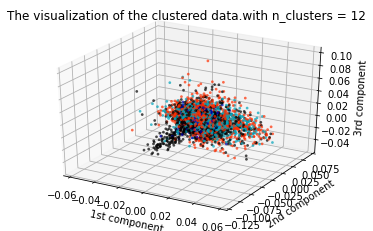

In [42]:
cluser =12
silhouette_and_data_plot(cluser, data_reduced_ICA, model_type='kmeans', data_type='reduced')

In [40]:
kmeans_model = KMeans(n_clusters=3, random_state=0)
kmeans_model.fit(data_reduced_ICA)


{0, 1, 2}


In [ ]:
# Compute the average scores for each cluster
#silhouette_avg = silhouette_score(X, cluster_labels)
# Compute the silhouette scores for each sample
cluster_labels = kmeans_model.labels_
sample_silhouette_values = silhouette_samples(data_reduced_ICA, cluster_labels)

In [47]:

label_sets = set(cluster_labels)
print(label_sets)

cluster_labels = np.asarray(cluster_labels)

for a_label in label_sets:
  print('label is',  a_label)
  print( len( np.where(cluster_labels==a_label)[0])  )

locs = np.where(cluster_labels==0)[0]
print(sample_silhouette_values[locs])
print(np.mean(sample_silhouette_values[locs]))

locs = np.where(cluster_labels==1)[0]
print(sample_silhouette_values[locs])
print(np.mean(sample_silhouette_values[locs]))

locs = np.where(cluster_labels==2)[0]
print(sample_silhouette_values[locs])
print(np.mean(sample_silhouette_values[locs]))

{0, 1, 2}
label is 0
2850
label is 1
5016
label is 2
2134
[-0.00632763 -0.01563068 -0.00225144 ... -0.06734901 -0.05579985
 -0.04721322]
-0.02416113
[0.08684395 0.1952754  0.08607487 ... 0.17388381 0.14605431 0.15469298]
0.13807294
[-0.07843556 -0.05642984 -0.11280934 ... -0.02009081 -0.04827427
 -0.06665321]
-0.061605852


In [48]:
# based on the above scores, we choose number of 3 classes in k-means clustering

################ Adding clustering labels and distance to its centroid as new features 
################ into the dimensionality reduced data

# based on above sihoutte score and distortion curve, choose cluster of 46 for k-means
kmeans_model   = KMeans(n_clusters=3, random_state=0)
kmeans_model.fit(data_reduced_ICA)
cluster_labels = kmeans_model.labels_
centers        = kmeans_model.cluster_centers_

# calculate the Eclidean distance between each point to its corresponding center.
dist_list = []
for n in range(len(data_reduced_ICA)):
    a_point         = data_reduced_ICA[n]          # get a point in the dataset
    a_cluster_label = cluster_labels[0]    # get the label of this point in the clusters
    my_center       = centers[a_cluster_label]
    dist            = np.sqrt(sum(a_point-my_center)**2)  # the distance between a given data point to its corresponding center
    dist_list.append(dist)

dist_list = np.asarray(dist_list)  # get all the distances
# concatenate the clustering label and the distance after the reduced dimension data, serving as additional features
data_reduced_ICA_features_Kmeans = np.concatenate(
    (data_reduced_ICA, cluster_labels[:, np.newaxis], dist_list[:, np.newaxis]),axis=1)

print(data_reduced_ICA_features_Kmeans.shape)

(10000, 162)


### EM clustering on data with reduced dimensionality using ICA

woring on clustering:  4
woring on clustering:  5
woring on clustering:  6
woring on clustering:  7
woring on clustering:  8
woring on clustering:  9
woring on clustering:  10
woring on clustering:  11
woring on clustering:  12
woring on clustering:  13
woring on clustering:  14


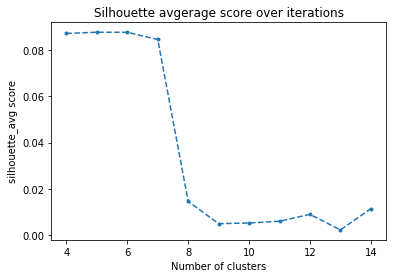

In [6]:
# Average silhouette score when using clustering from 2 to 10
max_cluster = [4, 15];
model_type = 'EM'
silhouette_avg_plot(data_reduced_ICA, max_cluster, model_type = model_type)


In [ ]:
# Bayesin Information Criterion score when using clustering from 2 to 10
#bic_plot(data_reduced_PCA, max_cluster)


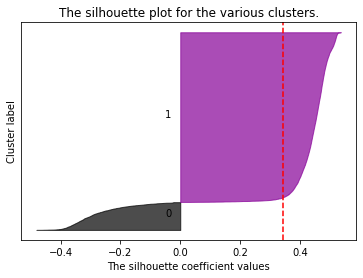

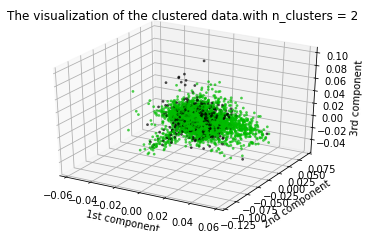

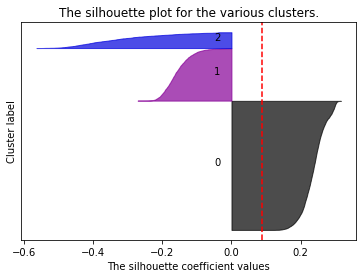

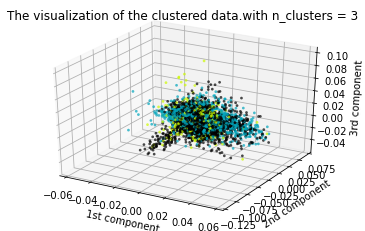

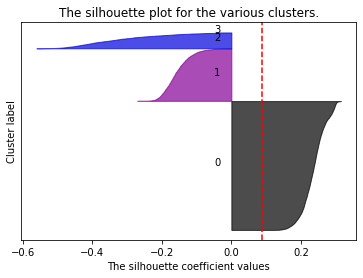

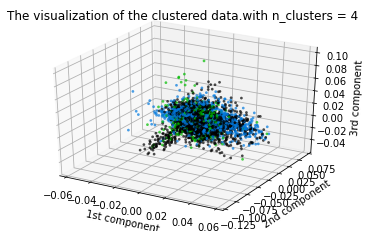

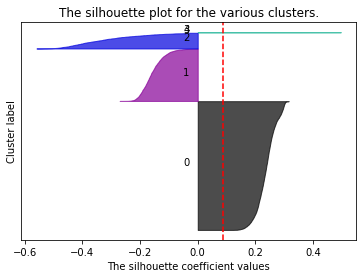

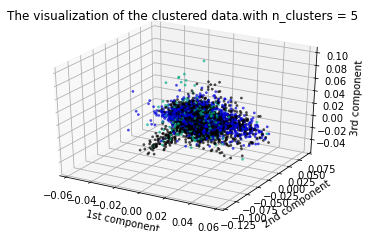

In [51]:
# plot the silhouette score over different clusters and visualize the data.
for cluser in [2, 3, 4, 5]:
    silhouette_and_data_plot(cluser, data_reduced_ICA, model_type='EM', data_type='reduced',
                             xlim=[], ylim=[], zlim=[])

In [52]:
################ Adding clustering labels and distance to its centroid as new features 
################ into the dimensionality reduced data

# based on above sihoutte score and bic curve, choose cluster of 2 for EM clustering
EM_model = GaussianMixture(n_components=2,random_state=0)
EM_model.fit(data_reduced_ICA)
cluster_labels = EM_model.predict(data_reduced_ICA)   

centers = EM_model.means_

# calculate the Eclidean distance between each point to its corresponding center.
dist_list = []
for n in range(len(data_reduced_ICA)):
    a_point = data_reduced_ICA[n]          # get a point in the dataset
    a_cluster_label = cluster_labels[0]    # get the label of this point in the clusters
    my_center = centers[a_cluster_label]
    dist = np.sqrt(sum(a_point-my_center)**2)  # the distance between a given data point to its corresponding center
    dist_list.append(dist)

dist_list = np.asarray(dist_list)  # get all the distances
# concatenate the clustering label and the distance after the reduced dimension data, serving as additional features
data_reduced_ICA_features_EM = np.concatenate(
    (data_reduced_ICA, cluster_labels[:, np.newaxis], dist_list[:, np.newaxis]),axis=1)

### Running neural network algrithm for classification on the dimension reduced data using ICA

In [53]:
## PCA reduced dimensionality data
NN_model = MLPClassifier(hidden_layer_sizes=(30,50,30), solver = 'adam',random_state=1, verbose=False,
                        activation         = 'relu',
                        alpha              = 0.001,    # L2 penalty (regularization term) parameter.
                        learning_rate_init = 0.001, # learning rate
                        shuffle            = False,  # whether to shuffle the data or not
                        )

# the  data with dimensionality reduction
X_train, X_test, y_train, y_test = train_test_split(data_reduced_ICA, mylabels, test_size=0.2, random_state=42)

NN_model.fit(X_train, y_train)
train_acc = NN_model.score(X_train, y_train)
print('Training accuracy is:', train_acc)

pred_test  = NN_model.predict(X_test)
test_acc  = metrics.accuracy_score(y_test, pred_test)
print('Testing accuracy is:', test_acc)

Training accuracy is: 0.979875
Testing accuracy is: 0.915


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [54]:
## PCA reduced dimensionality data + Kmean clustering labels and distance
NN_model = MLPClassifier(hidden_layer_sizes=(30,50,30), solver = 'adam',random_state=1, verbose=False,
                        activation         = 'relu',
                        alpha              = 0.001,    # L2 penalty (regularization term) parameter.
                        learning_rate_init = 0.001, # learning rate
                        shuffle            = False,  # whether to shuffle the data or not
                        )

# the  data with dimensionality reduction
X_train, X_test, y_train, y_test = train_test_split(data_reduced_ICA_features_Kmeans, mylabels, test_size=0.2, random_state=42)

NN_model.fit(X_train, y_train)
train_acc = NN_model.score(X_train, y_train)
print('Training accuracy is:', train_acc)

pred_test  = NN_model.predict(X_test)
test_acc  = metrics.accuracy_score(y_test, pred_test)
print('Testing accuracy is:', test_acc)

Training accuracy is: 0.980375
Testing accuracy is: 0.907


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [55]:
## PCA reduced dimensionality data + EM clustering labels and distance
NN_model = MLPClassifier(hidden_layer_sizes=(30,50,30), solver = 'adam',random_state=1, verbose=False,
                        activation         = 'relu',
                        alpha              = 0.001,    # L2 penalty (regularization term) parameter.
                        learning_rate_init = 0.001, # learning rate
                        shuffle            = False,  # whether to shuffle the data or not
                        )

# the  data with dimensionality reduction
X_train, X_test, y_train, y_test = train_test_split(data_reduced_ICA_features_EM, mylabels, test_size=0.2, random_state=42)

NN_model.fit(X_train, y_train)
train_acc = NN_model.score(X_train, y_train)
print('Training accuracy is:', train_acc)

pred_test  = NN_model.predict(X_test)
test_acc  = metrics.accuracy_score(y_test, pred_test)
print('Testing accuracy is:', test_acc)

Training accuracy is: 0.9725
Testing accuracy is: 0.9125


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
